In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sys
import pdb
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter1d

In [3]:
from matplotlib.patches import Rectangle
import mpl_toolkits.mplot3d.art3d as art3d

In [4]:
sys.path.append('/home/akumar/nse/neural_control')
sys.path.append('/home/akumar/nse/neural_control/analysis_scripts')

In [5]:
from loaders import load_sabes
from segmentation import reach_segment_sabes
from utils import apply_df_filters
from psth_ilmerge import get_top_neurons

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Grab the ordering of top neurons
# Add data_path, T, n, bin_width to globals
# Set these
data_path = '/mnt/Secondary/data/sabes'
T = 30
n = 10
bin_width = 50

globals()['data_path'] = data_path
globals()['T'] =  T
globals()['n'] = n
globals()['bin_width'] = bin_width

# Load dimreduc_dfs
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    dimreduc_df = pd.DataFrame(pickle.load(f))

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)    

dimreduc_df = pd.concat([dimreduc_df, loco_df])

method1 = 'FCCA'
method2 = 'PCA'

# Get top neurons
top_neurons_df, loadings_df = get_top_neurons(dimreduc_df, method1='FCCA', method2='PCA', n=20, pairwise_exclude=False, data_path=data_path, T=T, bin_width=bin_width)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
35it [00:00, 48.61it/s]
35it [00:00, 489.83it/s]


Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]
/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


Reminder that start times depend on the bin size


/tmp/ipykernel_13853/693855603.py:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1spike_raster_ordered.pdf', bbox_inches='tight', pad_inhces=0)


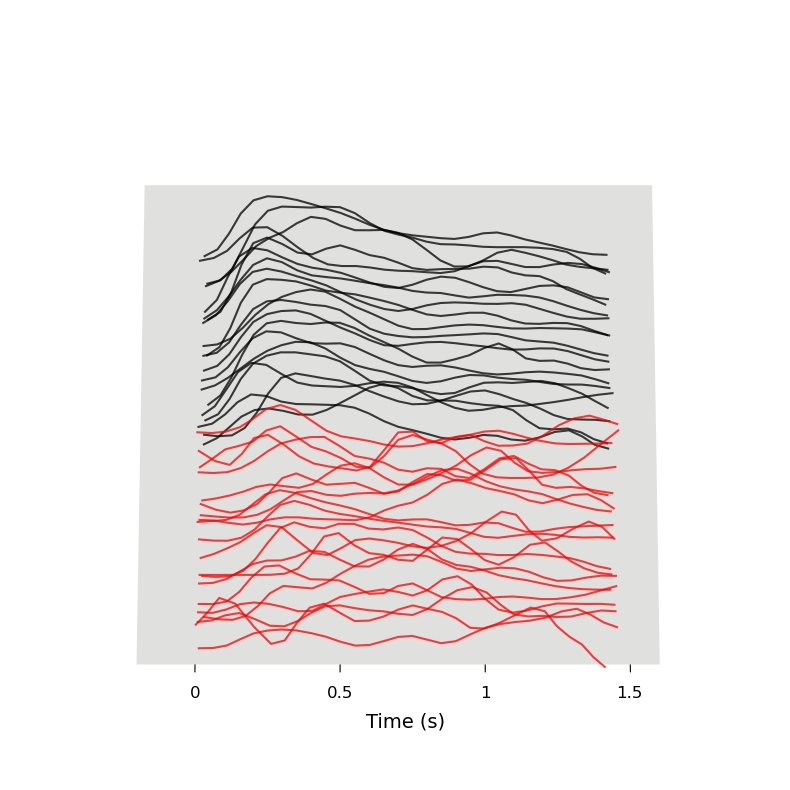

In [13]:
T = 30
# (Bin size 50 ms)
time = 50 * np.arange(T)
n = 20
# Engineer maximum contrast between traces
data_file_fca ='indy_20160624_03.mat'
data_file_pca ='indy_20160930_02.mat'
data_path = '/mnt/Secondary/data/sabes'


fig = plt.figure(figsize=(25,10))
ax = plt.axes(projection='3d')

ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))a

#p = Rectangle((-10, -10), 100, 125, alpha=0.25)
#ax.add_patch(p)
#art3d.pathpatch_2d_to_3d(p, z=0, zdir="z")
#art3d.pathpatch_translate(p, (0.5, 1, 0))

# PCA
df_ = apply_df_filters(top_neurons_df, data_file=data_file_pca)
dat = load_sabes('%s/%s' % (data_path, data_file_pca), boxcox=None, high_pass=False)
dat_segment = reach_segment_sabes(dat, data_file=data_file_pca.split('.mat')[0])

t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

for j in range(n):
    tn = df_.iloc[0]['top_neurons'][1, j]    
    x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                for idx in valid_transitions])
    
    x_ = StandardScaler().fit_transform(x_.T).T
    # Upscale
    x_ = scipy.signal.resample(x_, 100)
    x_ = gaussian_filter1d(x_, sigma=1.25)
    x_ = np.mean(x_, axis=0)
    ax.plot((2*j) * np.ones(x_.size), np.arange(x_.size), x_/np.max(x_), 'k', alpha=0.75, zorder=9)

# FCCA
df_ = apply_df_filters(top_neurons_df, data_file=data_file_fca)
dat = load_sabes('%s/%s' % (data_path, data_file_fca), boxcox=None, high_pass=False)
dat_segment = reach_segment_sabes(dat, data_file=data_file_fca.split('.mat')[0])

t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

for j in range(n):
    tn = df_.iloc[0]['top_neurons'][0, j]    
    x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                for idx in valid_transitions])
    
    x_ = StandardScaler().fit_transform(x_.T).T
    x_ = scipy.signal.resample(x_, 100)
    x_ = gaussian_filter1d(x_, sigma=1.25)
    x_ = np.mean(x_, axis=0)
    ax.plot((2*(j + n)) * np.ones(x_.size), np.arange(x_.size), x_/np.max(x_), 'r', alpha=0.75, zorder=10)

ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=12)
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)

x = [-9,84,84,-9]
y = [-4,-4,32,32]
z = [0,0,0,0]
verts = [list(zip(x,y,z))]
ax.add_collection3d(art3d.Poly3DCollection(verts, facecolors='#e0e0de', alpha=1., zorder=0))

fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1spike_raster_ordered.pdf', bbox_inches='tight', pad_inhces=0)

In [14]:
# Now do the same thing for S1

data_path = '/mnt/Secondary/data/sabes'
T = 30
n = 20
bin_width = 50

# Load dimreduc_dfs
good_loco_files = ['loco_20170210_03.mat',
                'loco_20170213_02.mat',
                'loco_20170215_02.mat',
                'loco_20170227_04.mat',
                'loco_20170228_02.mat',
                'loco_20170301_05.mat',
                'loco_20170302_02.mat']

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_df.dat', 'rb') as f:
    rl2 = pickle.load(f)

loco_df = pd.DataFrame(result_list)
indy_df = pd.DataFrame(rl2)
loco_df = apply_df_filters(loco_df, data_file=good_loco_files, decoder_args=loco_df.iloc[0]['decoder_args'])
indy_df = apply_df_filters(indy_df, decoder_args=indy_df.iloc[0]['decoder_args'])
sabes_df = pd.concat([loco_df, indy_df])        
loader_arg = {'bin_width':50, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100, 'region':'S1'}
sabes_df = apply_df_filters(sabes_df, loader_args=loader_arg)

dimreduc_df = sabes_df

method1 = 'FCCA'
method2 = 'PCA'

# Get top neurons
top_neurons_dfS1, _ = get_top_neurons(dimreduc_df, method1=method1, method2=method2, n=20, pairwise_exclude=False, data_path=data_path, T=T, bin_width=bin_width)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
8it [00:00, 107.74it/s]
8it [00:00, 463.41it/s]


NameError: name 'top_neurons_dfS1' is not defined

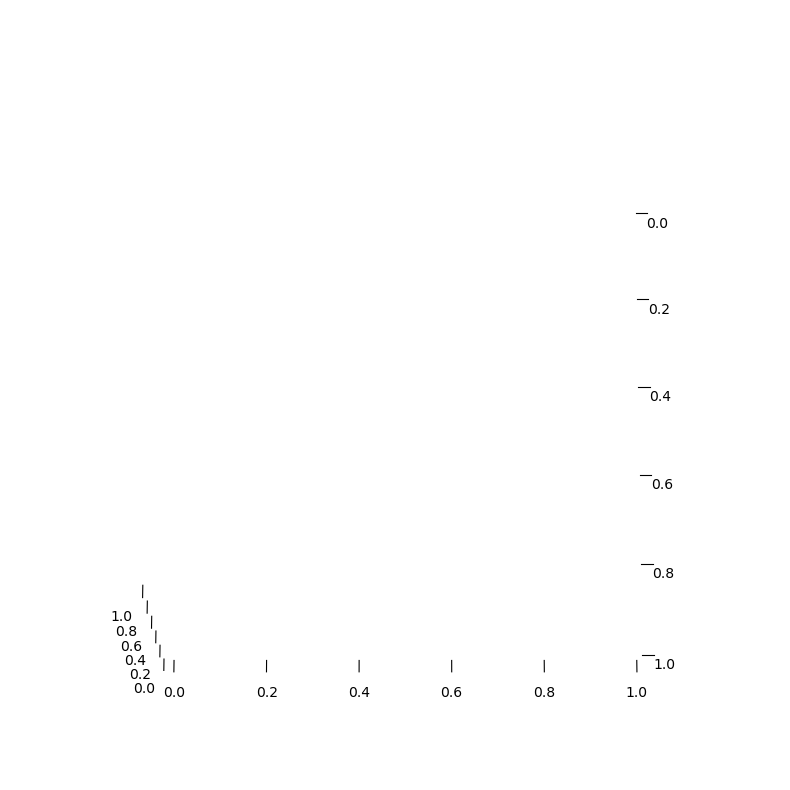

In [8]:
T = 30
# (Bin size 50 ms)
time = 50 * np.arange(T)
n = 20
# Engineer maximum contrast between traces
data_file_fca ='loco_20170215_02.mat'
data_file_pca ='indy_20160426_01.mat'
data_path = '/mnt/Secondary/data/sabes'


fig = plt.figure(figsize=(25,10))
ax = plt.axes(projection='3d')

ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# PCA
df_ = apply_df_filters(top_neurons_dfS1, data_file=data_file_pca)
dat = load_sabes('%s/%s' % (data_path, data_file_pca), boxcox=None, high_pass=False, region='S1')
dat_segment = reach_segment_sabes(dat, data_file=data_file_pca.split('.mat')[0])

t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

for j in range(n):
    tn = df_.iloc[0]['top_neurons'][1, j]    
    x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                for idx in valid_transitions])
    
    x_ = StandardScaler().fit_transform(x_.T).T
    # Upscale
    x_ = scipy.signal.resample(x_, 100)
    x_ = gaussian_filter1d(x_, sigma=1.25)
    x_ = np.mean(x_, axis=0)
    ax.plot((2*j) * np.ones(x_.size), np.arange(x_.size), x_/np.max(x_), 'k', alpha=0.75, zorder=9)

# FCCA
df_ = apply_df_filters(top_neurons_dfS1, data_file=data_file_fca)
dat = load_sabes('%s/%s' % (data_path, data_file_fca), boxcox=None, high_pass=False, region='S1')
dat_segment = reach_segment_sabes(dat, data_file=data_file_fca.split('.mat')[0])

t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

for j in range(n):
    tn = df_.iloc[0]['top_neurons'][0, j]    
    x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T, tn] 
                for idx in valid_transitions])
    
    x_ = StandardScaler().fit_transform(x_.T).T
    x_ = scipy.signal.resample(x_, 100)
    x_ = gaussian_filter1d(x_, sigma=1.25)
    x_ = np.mean(x_, axis=0)
    ax.plot((2*(j + n)) * np.ones(x_.size), np.arange(x_.size), x_/np.max(x_), 'r', alpha=0.75, zorder=10)

ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=12)
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)

x = [-9,84,84,-9]
y = [-4,-4,32,32]
z = [0,0,0,0]
verts = [list(zip(x,y,z))]
ax.add_collection3d(art3d.Poly3DCollection(verts, facecolors='#e0e0de', alpha=1., zorder=0))


fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/S1spike_raster_ordered.pdf', bbox_inches='tight', pad_inhces=0)

In [34]:
ax.get_ylim()

(-1.4500000000000002, 30.45)